In [4]:
with open('names.txt', 'r') as f:
    names = f.read().split('\n')

names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(names)

32033

In [25]:
# Build vocabulary
vocab = []
for name in names:
    vocab += name
vocab = sorted(set(vocab))

# Build mapping from letter to integer id and for id to letter
itos = { i+1:l for i, l in enumerate(vocab)}
# Additional `point` at index 0
itos[0] = '.'
stoi = { l:i for i, l in itos.items()}

In [124]:
# Build a dataset
import torch

# Context lenght -> How many characters we take to predict the next
block_size = 3

# Inputs
X = []
# Targets
Y = []

# For each name
for word in names[:5]:
    # The start is an empty new context (which contains our designed dot special character)
    context = [0] * block_size
    # For each character in the name (adding dot as a stopping token)
    for ch in word + '.':
        # We add the current context and as an input to the dataset
        X.append(context)
        # Get the index of the current character and add it as a target for a potential
        # generated new character that could follow this context
        idx_ch = stoi[ch]
        Y.append(idx_ch)
        # Slide the context window and add the new character to it
        context = context[1:] + [idx_ch]

# View demo of dataset
def dataset_demo():
    for i, p in zip(X[:20], Y[:20]):
        print([itos[c] for c in i], "-->", itos[p])

    
X = torch.Tensor(X).long()
Y = torch.Tensor(Y).long()

In [125]:
X.dtype

torch.int64

In [63]:
# Create the embedding
# Each element gets a 2 value embedding
C = torch.randn((27, 2))
# Because of pytorch, we can index into the C table using a list or a list of lists
# X in this case
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [64]:
# Initializing the model parameters
W1 = torch.randn((3 * 2, 100))
b1 = torch.randn(100)

In [72]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [73]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
# Output of the final layer
logits = h @ W2 + b2 # log-counts
logits.shape

torch.Size([32, 27])

In [74]:
# Nomarlisation

In [90]:
# Normalisr the rows to convert logits into probabilities
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])


torch.Size([32, 27])

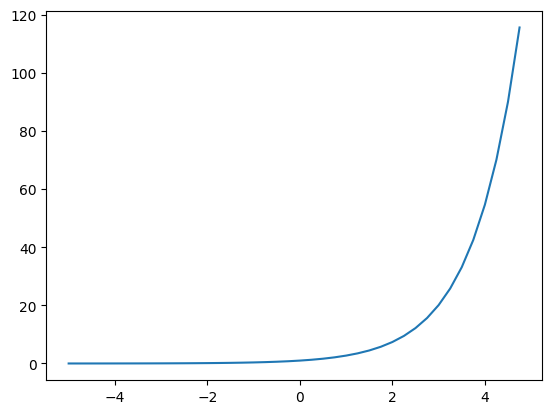

In [87]:
import numpy as np
a = np.arange(-5., 5., 0.25)
import matplotlib.pyplot as plt
import math
plt.plot(a, [math.exp(i) for i in a])


In [91]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0],
       dtype=torch.int32)

In [102]:
# Log will output from value from 0 (max, when all probs/predictions are 1.0)
# all the way to -inf
# Mean is used to gather them up
# minus is used to make the loss positive
loss = -prob[torch.arange(32), Y].log().mean()

tensor(inf)

In [126]:
g = torch.Generator().manual_seed(0x1337_b00b)
# Create the embedding
C = torch.randn((27, 2), generator=g)
emb = C[X]
# Initializing the model parameters
# First layer
W1 = torch.randn((3 * 2, 100), generator=g)
b1 = torch.randn(100, generator=g)
# Second layer
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

# Forward pass
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2 # log-counts

def manual_loss():
    # Normalise the rows to convert logits into probabilities
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    # Compute the loss over all the 32 inputs
    loss_manual = -probs[torch.arange(32), Y].log().mean()
    print(loss_manual)

In [128]:
from torch.nn import functional as F
loss = F.cross_entropy(logits, Y)
loss

tensor(14.0110)